# Image classification with Convolutional Neural Networks

Welcome to the first week of the second deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Introduction to our first task: 'Dogs vs Cats'

We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

Here is the dataset http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. "wget http://files.fast.ai/data/dogscats.zip"

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

PATH = "data/fish/"

In [77]:
from fastai.plots import *

In [42]:
from fastai.io import get_data

### First look at fish pictures

In [25]:
!ls {PATH}

all.json  sample			  test		 train
annos	  sample_submission_stg1.csv	  test_stg1.zip  train.zip
models	  sample_submission_stg1.csv.zip  tmp		 valid


In [26]:
!ls {PATH}valid

ALB  BET  DOL  LAG  NoF  OTHER	SHARK  YFT


In [27]:
files = !ls {PATH}valid/ALB | head
files

['img_00039.jpg',
 'img_00057.jpg',
 'img_00074.jpg',
 'img_00154.jpg',
 'img_00219.jpg',
 'img_00269.jpg',
 'img_00274.jpg',
 'img_00290.jpg',
 'img_00337.jpg',
 'img_00396.jpg']

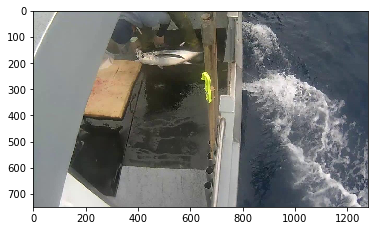

In [28]:
img = plt.imread(f'{PATH}valid/ALB/{files[0]}')
plt.imshow(img);

### Our first model: quick start

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds of compute time:

In [81]:
sz=299

In [82]:
tfms = tfms_from_model(resnet34, sz)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')

In [83]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam)

In [84]:
learn.fit(0.01, 3)

A Jupyter Widget

[ 0.      0.5848  0.4458  0.8771]                         
[ 1.      0.4945  0.3102  0.9255]                          
[ 2.      0.3896  0.2852  0.909 ]                          



In [85]:
lrs=np.array([1e-4,1e-3,1e-2])
learn.precompute=False

In [17]:
learn.freeze_to(6)

In [18]:
learn.fit(lrs/10, 2, cycle_len=1)

A Jupyter Widget

[ 0.      0.657   0.4393  0.8631]                         
[ 1.      0.6502  0.3334  0.904 ]                          



In [7]:
learn.lr_find(lrs/1e3)

A Jupyter Widget

 81%|████████  | 42/52 [00:27<00:04,  2.39it/s, loss=1.72] 

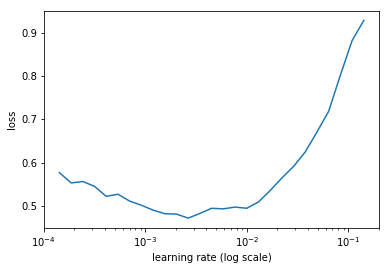

In [8]:
learn.sched.plot()

In [6]:
import json
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [45]:
def get_annotations():
    annot_urls = [
        '5458/bet_labels.json', '5459/shark_labels.json', '5460/dol_labels.json',
        '5461/yft_labels.json', '5462/alb_labels.json', '5463/lag_labels.json'
    ]
    cache_subdir = os.path.abspath(os.path.join(PATH, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    os.makedirs(cache_subdir, exist_ok=True)
    
    for url_suffix in annot_urls:
        fname = url_suffix.rsplit('/', 1)[-1]
        get_data(url_prefix + url_suffix, f'{cache_subdir}/{fname}')

In [23]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open(f'{PATH}annos/{c}_labels.json', 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [59]:
get_annotations()

In [70]:
raw_filenames,raw_val_filenames,raw_test_filenames = [
    [f.split('/')[-1] for f in ds.fnames] for ds in (data.trn_ds, data.val_ds, data.test_dl.dataset)]

In [90]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    bb[2] = max(bb[2], 0)
    bb[3] = max(bb[3], 0)
    return bb

In [72]:
sizes = [PIL.Image.open(PATH+f).size for f in data.trn_ds.fnames]
raw_val_sizes = [PIL.Image.open(PATH+f).size for f in data.val_ds.fnames]

In [91]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)

In [98]:
trn_bb_labels = [f + ',' + ' '.join(map(str,o))+'\n' for f,o in zip(raw_filenames,trn_bbox)]

In [100]:
open(f'{PATH}trn_bb_labels', 'w').writelines(trn_bb_labels)

In [103]:
label_csv=f'{PATH}trn_bb_labels'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [108]:
data = ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms, val_idxs=val_idxs,
                                    continuous=True, skip_header=False)

In [109]:
data.trn_ds[0]

(array([[[-0.1644, -0.1185, -0.048 , ...,  0.0488,  0.1777,  0.1814],
         [-0.162 , -0.11  , -0.0458, ..., -0.0795,  0.0683,  0.2224],
         [-0.2323, -0.0608, -0.1314, ..., -0.8063, -0.9513, -0.8675],
         ..., 
         [-0.9236, -0.8982, -0.9283, ..., -1.3108, -1.272 , -1.2105],
         [-0.9089, -0.8701, -0.9617, ..., -1.3108, -1.272 , -1.2105],
         [-0.9089, -0.8701, -0.9877, ..., -1.3108, -1.272 , -1.2105]],
 
        [[ 0.1715,  0.2184,  0.2905, ...,  0.7045,  0.8364,  0.8401],
         [ 0.1739,  0.2271,  0.2927, ...,  0.5734,  0.7244,  0.8821],
         [ 0.1021,  0.2774,  0.2052, ..., -0.1696, -0.3179, -0.2322],
         ..., 
         [-0.7797, -0.7538, -0.7845, ..., -0.9129, -0.8733, -0.8104],
         [-0.7647, -0.725 , -0.8186, ..., -0.9129, -0.8733, -0.8104],
         [-0.7647, -0.725 , -0.8452, ..., -0.9129, -0.8733, -0.8104]],
 
        [[ 0.3233,  0.3699,  0.4765, ...,  0.9585,  1.0897,  1.0935],
         [ 0.3257,  0.3786,  0.4788, ...,  0.828 ,  0.

In [78]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plots(data.val_ds.denorm(data.val_ds[i][0]))
    plt.gca().add_patch(create_rect(bb))

[  36.459    27.4466  111.7049   52.9836]


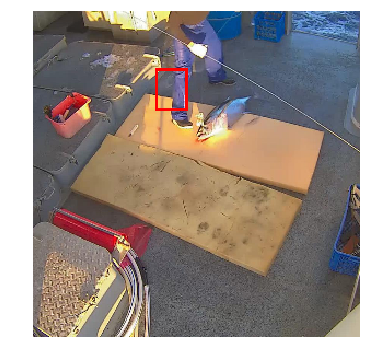

In [80]:
show_bb(0)

In [87]:
val_bbox.shape

(500, 4)

### Analyzing results: looking at pictures

In [6]:
from fastai.plots import *

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [7]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [10]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
print(log_preds.shape)
log_preds[:10]

(2000, 2)


array([[ -1.4870e-02,  -4.2159e+00],
       [ -2.5129e-04,  -8.2892e+00],
       [ -2.4796e-05,  -1.0593e+01],
       [ -8.6451e-04,  -7.0536e+00],
       [ -1.9741e-04,  -8.5299e+00],
       [ -1.5791e-02,  -4.1562e+00],
       [ -1.2398e-05,  -1.1289e+01],
       [ -1.1396e-04,  -9.0806e+00],
       [ -5.2452e-06,  -1.2111e+01],
       [ -1.5533e-03,  -6.4681e+00]], dtype=float32)

In [11]:
# from log probabilities to 0 or 1
preds = np.argmax(log_preds, axis=1)
# here is the probs of cat
probs = np.exp(log_preds[:,0])

In [12]:
# 1. A few correct labels at random
correct = np.where((preds == data.val_y))
corr_ind = np.random.choice(correct[0], 4, replace=False)
imgs = np.stack([data.val_ds[x][0] for x in corr_ind])
title_probs = [probs[x] for x in corr_ind]

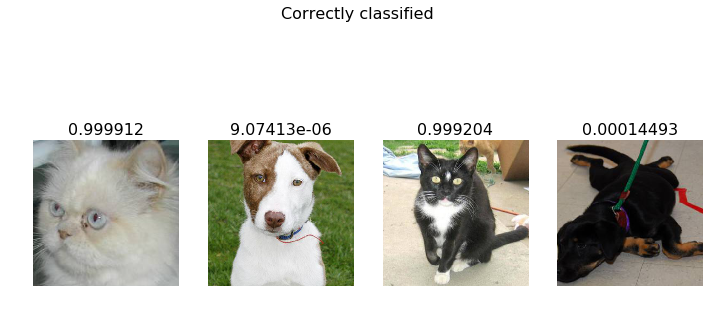

In [13]:
plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs ,maintitle="Correctly classified")

In [14]:
# 2. A few incorrect labels at random
incorrect = np.where((preds != data.val_y))
ind = np.random.choice(incorrect[0], 4, replace=False)
imgs = np.stack([data.val_ds[x][0] for x in ind])
title_probs = [probs[x] for x in ind]

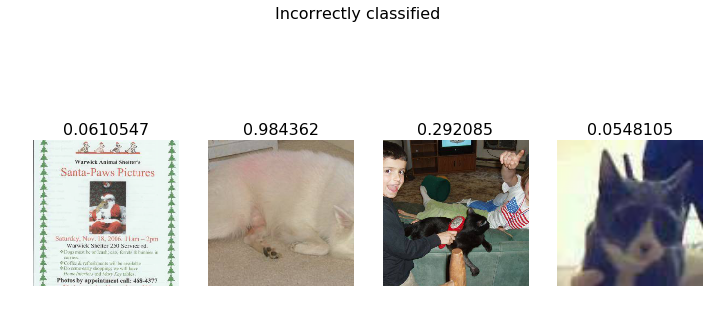

In [15]:
plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs ,maintitle="Incorrectly classified")

In [16]:
#3(a) Most correct cats
correct_cats = np.where((preds == data.val_y) & (data.val_y == 0))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:4]
imgs = np.stack([data.val_ds[x][0] for x in correct_cats[most_correct_cats]])
title_probs = [probs[x] for x in correct_cats[most_correct_cats]]

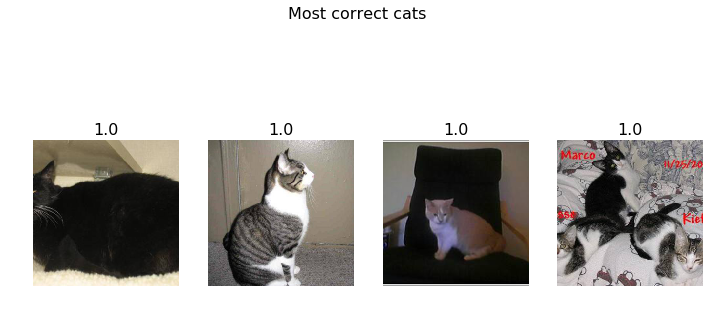

In [17]:
plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs ,maintitle="Most correct cats")

In [18]:
# 3(b). Most correct dogs
correct_dogs = np.where((preds == data.val_y) & (data.val_y == 1))[0]
most_correct_dogs = np.argsort(-probs[correct_dogs])[::-1][:4]
imgs = np.stack([data.val_ds[x][0] for x in correct_dogs[most_correct_dogs]])
title_probs = [probs[x] for x in correct_dogs[most_correct_dogs]]

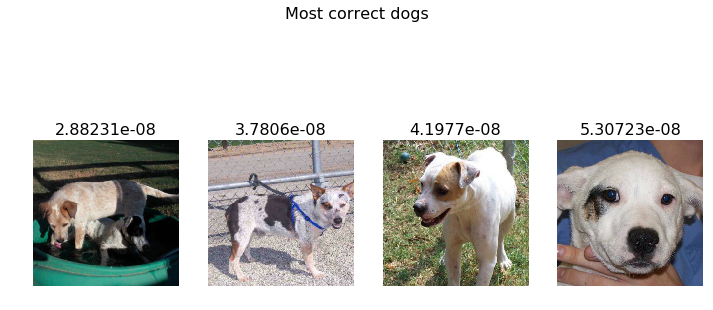

In [19]:
plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs ,maintitle="Most correct dogs")

In [20]:
# 4(a) The most incorrect cats
incorrect_cats = np.where((preds != data.val_y) & (data.val_y == 0))[0]
most_incorrect_cats = np.argsort(-probs[incorrect_cats])[::-1][:4]
imgs = np.stack([data.val_ds[x][0] for x in incorrect_cats[most_incorrect_cats]])
title_probs = [probs[x] for x in incorrect_cats[most_incorrect_cats]]

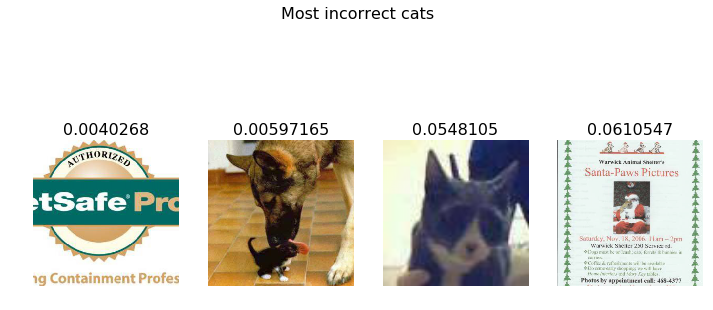

In [21]:
plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs, maintitle="Most incorrect cats")

In [22]:
# 4(b) The most incorrect dogs
incorrect_dogs = np.where((preds != data.val_y) & (data.val_y == 1))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1][:4]
imgs = np.stack([data.val_ds[x][0] for x in incorrect_dogs[most_incorrect_dogs]])
title_probs = [probs[x] for x in incorrect_dogs[most_incorrect_dogs]]

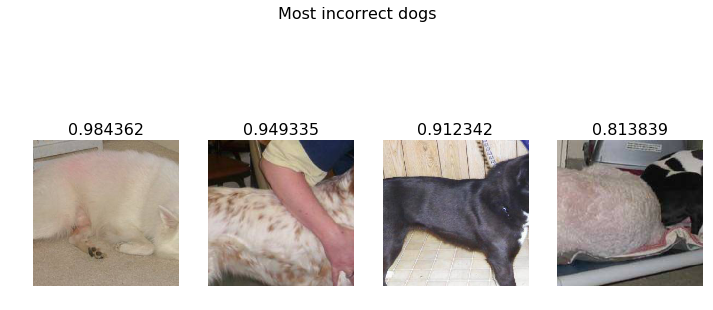

In [23]:
plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs, maintitle="Most incorrect dogs")

In [24]:
#5. The most uncertain labels
most_uncertain = np.argsort(-np.abs(probs -0.5))[::-1][:8]
imgs = np.stack([data.val_ds[x][0] for x in most_uncertain])
title_probs = [(probs[x], data.val_y[x]) for x in most_uncertain]

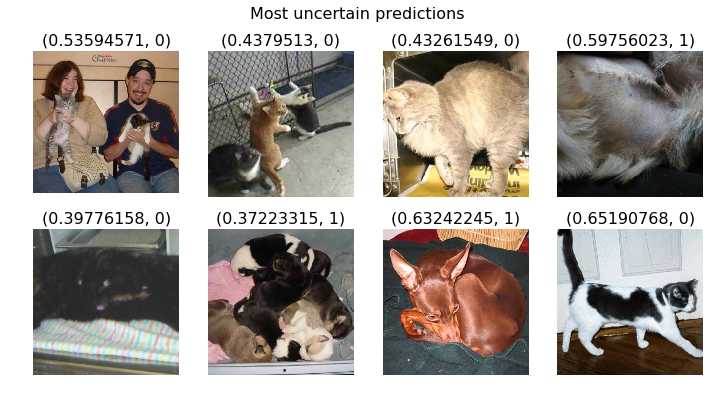

In [25]:
plots(data.val_ds.denorm(imgs), rows=2, titles=title_probs, maintitle="Most uncertain predictions")

### Analyzing results: confusion matrix 

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [172]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[994   6]
 [ 11 989]]


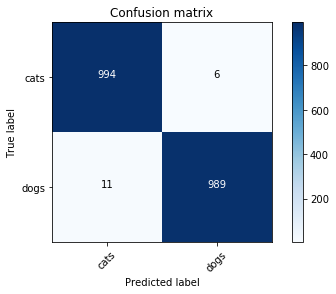

In [174]:
plot_confusion_matrix(cm, data.classes)

How to read the confusion matrix? In the x axis we have the predicted label. In the y axis we have the True label. For example, there are 6 cats that are predicted as dogs and 11 dogs that are predicted to be cats.

### Analyzing results: loss and accuracy

In [175]:
learn.fit(0.001, 1)

[ 0.      0.0306  0.0238  0.9917]                              



When we run `learn.fit` we print 3 performance values (see above.) Here 0.0306 is the value of the **loss** in the training set, 0.0238 is the value of the loss in the validation set and 0.9917 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example $x, y$ in binary classification is given by:
$$- [y \cdot \log p + (1-y) \cdot \log (1-p)]$$
where $y$ is the true label of $x$ and $p$ is the probability predicted by our model that the label is 1.

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image $x$ with label $1$ your model gives a probability 0.9. For this case the loss should be small because our model is predicting 1 with high probability.

$$Loss(x) = - \log(0.9) = 0.10$$

Now suppose $x$ has label 0 but our model is predicting 0.9. In this case our loss is.

$$Loss(x) = - \log(1-0.9) = 2.30$$

Exercice: look at the other cases and convinced yourself that this make sense. 

Why not to just maximize accuracy? The binary classification loss is an easier function to optimize.

### Layers

Neural networks consist of **linear layers alternating with non-linear layers**.  This creates functions which are incredibly flexible.  Deeper layers are able to capture more complex patterns.

Layer 1 of a convolutional neural network:
<img src="images/zeiler1.png" alt="pytorch" style="width: 40%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Layer 2:
<img src="images/zeiler2.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Deeper layers can learn about more complicated shapes (although we are only using 2 layers in our network):
<img src="images/zeiler4.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

### SGD, fitting, linear regression

Now we look lesson1-sgd.ipynb were we explain: SGD, fitting, linear regression and parameters.

### Understanding the code for our first model

Let's look at this code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing (we are going to use size 299x299 images), image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [6]:
tfms = tfms_from_model(resnet34, 299)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [7]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.

<img src="images/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [8]:
learn = ConvLearner.pretrained(resnet34, data)

`learn.precompute=True` tells the library to use a trick that makes initial training go faster. All layers but the last one are used as a feature extractor. For every image in the training set we get a vector of *activations*. Using these pre-trained activations we can train the last layer of the network. 

In [16]:
learn.precompute=True

We already know what are parameters which are learned by fitting a model to the data. **Hyparameters** are another kind of parameters that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, an **epoch** is a single pass through the entire training set.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyparameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [17]:
learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.      0.0364  0.0229  0.9912]                              
[ 1.      0.0301  0.0216  0.9927]                              



### Choosing a learning rate

** Needs much more about learning rates here **

The **learning rate** determines how quickly or how slowly you want to update the weight parameters in gradient descent. Usually, you want to start with a large learning rate, and gradually decrease the learning rate as the training progresses. 

`learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like. Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

A Jupyter Widget

 87%|████████▋ | 314/360 [00:48<00:06,  7.45it/s, loss=0.367] 

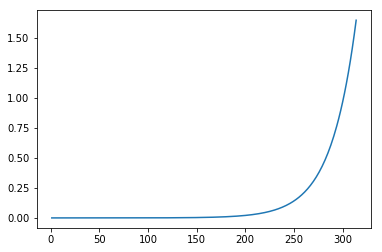

In [9]:
lrf=learn.lr_find()
learn.sched.plot_lr()

** We need to explain the concept of a 'batch' for this chart to make sense **

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

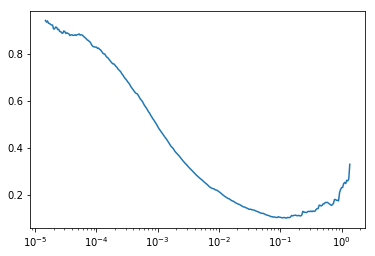

In [10]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use (ignore the first few batches, since there wasn't enough history to have a meaningful average). Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

### Improving our model

#### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizaing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [12]:
from fastai.plots import *

In [13]:
tfms = tfms_from_model(resnet34, 299, aug_tfms=transforms_side_on, max_zoom=1.1)

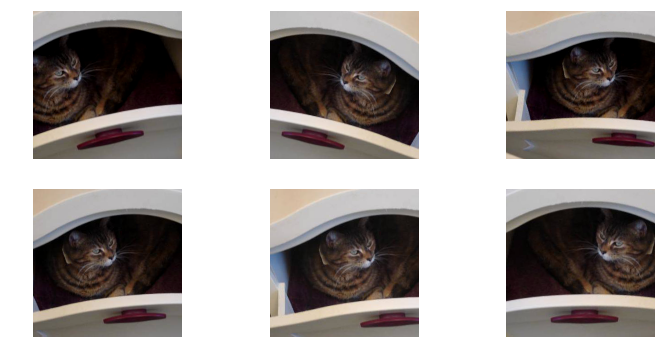

In [24]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [14]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

We fit the final layer from the pre-computed activations as before, but just for one epoch this time to get it started quickly.

In [15]:
learn.fit(1e-2, 1)

A Jupyter Widget

[ 0.      0.0407  0.0247  0.9897]                              



To use our augmented data, we can no longer pre-compute the penultimate layer's activations - we never see the exact same picture twice since we have random augmentations, so we don't have the same activations. Therefore we disable `precompute`, the attribute that toggles the use of pre-computed activations.

In [16]:
learn.precompute = False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that even although we're not using the precomputed activations any more, it's still only updating the weights in the last layer when we call `fit`.

In [17]:
learn.fit(1e-2, 3)

A Jupyter Widget

[ 0.      0.041   0.0221  0.9917]                             
[ 1.      0.0377  0.0252  0.9893]                             
[ 2.      0.036   0.0256  0.9912]                             



Our validation loss isn't improving much, so there's probably no point further training the last layer on its own. But there is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [18]:
accuracy(*learn.TTA())

0.99450000000000005

I generally see about a 30% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [19]:
learn.save('299_fc')

#### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [20]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [21]:
lr=np.array([1e-4,1e-3,1e-2])

In [22]:
learn.fit(lr, 2, cycle_len=2)

A Jupyter Widget

[ 0.      0.0514  0.0214  0.9937]                             
[ 1.      0.0299  0.0194  0.9927]                             
[ 2.      0.038   0.0164  0.9937]                             
[ 3.      0.0259  0.0151  0.9937]                             



Why did this complete 4 epochs when we passed an argument of 2? And what is that `cycle_len` parameter? What we've done here is used a technique called *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate, which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

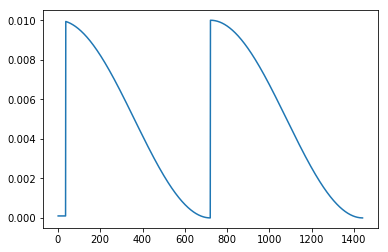

In [23]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

You should find our TTA accuracy has improved a little more.

In [25]:
accuracy(*learn.TTA())

0.995

In [10]:
x.shape

(3, 299, 299)